This notebook is the data analysis and derivation of the general text preprocessing techniques used in [CS4248-Project](https://github.com/fangpinsern/CS4248-Project). Detailed explanations for this portion can be found in Section III-A and Section V-A of the [project report](https://github.com/fangpinsern/CS4248-Project/blob/master/CS4248_Group_Report.pdf). 

This notebook can be run independently from other code files in the project. Follow the instructions in the code below to obtain the files necessary for running this notebook.

Author: @wenmogu

# Run the following if you wish to run this file on Google Golab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# change the working_dir value to your working directory
working_dir = '/content/gdrive/My Drive/NLP Group Project 2/'
# someone else's working_dir:
# working_dir = ...

In [ ]:
import sys
sys.path.append(working_dir)

# Imports

In [ ]:
import os

import numpy as np 
import pandas as pd 
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import pickle

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import csv

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('universal_tagset')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

Uncomment and run the line below if you wish to run the section where we train mitten model to obtain glove vectors for bigram tokens

In [ ]:
# pip install -U mittens

# Constants and Paths

In [ ]:
JSON_FILE = os.path.join(working_dir, 'News_Category_Dataset_v2.json')
# download from: https://drive.google.com/file/d/1xF5vGE-nhZBDA_9CwIiSmAFiI2AN_vUo/view?usp=sharing
CATEGORY_SUBSET = ['CRIME', 'RELIGION', 'TECH', 'MONEY', 'FOOD & DRINK', 'SPORTS', 'TRAVEL', 'WOMEN', 'STYLE', 'ENTERTAINMENT']

TRAIN_TEST_SPLIT_DATASET = os.path.join(working_dir, 'train_test_split_dataset.csv')
# download from: https://drive.google.com/file/d/1h7WzzH9Q0xzCey1szS_w29soYGV-O31L/view?usp=sharing
# it can also be generated by running train_test_split()

BIGRAM_TRIGRAM_VOCAB = os.path.join(working_dir, "bigram_trigram_vocab_PMI.csv")
# download from: https://github.com/fangpinsern/CS4248-Project/blob/master/proj/vocab/bigram_trigram_vocab_PMI.csv

GLOVE_50D_TXT = os.path.join(working_dir, "glove.6B.50d.txt")
# download from: https://drive.google.com/file/d/1b5Gfz8RZJUemguigVrLfhXfuCZ96kW1c/view?usp=sharing

BIGRAM_VOCAB_EMBEDDINGS = os.path.join(working_dir, "mitten_bigram_dict_50d_515_10000.pkl")
# download from: https://github.com/fangpinsern/CS4248-Project/blob/master/proj/vocab/mitten_bigram_dict_50d_515_10000.pkl

# Utility Functions

## Get dataset

In [ ]:
def get_dataset():
    a = pd.read_json(JSON_FILE, lines=True)
    a = a.drop(a[a['headline']==''].index.values)
    a = a[a['category'].isin(CATEGORY_SUBSET)]
    return a[['headline', 'category']]

In [ ]:
def train_test_split(percent_train=0.7, percent_dev=0.1, percent_test=0.2):
    if os.path.exists(TRAIN_TEST_SPLIT_DATASET):
      data = pd.read_csv(TRAIN_TEST_SPLIT_DATASET)
      return data

    data = get_dataset()
    l = len(data)
    train_num = int(l*0.7)
    dev_num = int(l*0.1)
    rnd_ind = np.arange(l)
    np.random.shuffle(rnd_ind)
    train_ind = rnd_ind[:train_num]
    dev_ind = rnd_ind[train_num:train_num+dev_num]
    test_ind = rnd_ind[train_num+dev_num:]
    data = data.reset_index()
    data['ind'] = data.index

    def change_phase(ind):
      if ind in train_ind:
        return 'train'
      elif ind in dev_ind:
        return 'dev'
      else:
        return 'test'

    data['phase'] = data['ind'].apply(change_phase)
    data = data.drop(columns=['ind'])

    data.to_csv(TRAIN_TEST_SPLIT_DATASET, index=False)

    return data

In [ ]:
def balanced_train_test_split(percent_train=0.7, percent_dev=0.1, percent_test=0.2, count=2000):
    def balance_train_data(train_data, count):
      ret = None
      for cat in CATEGORY_SUBSET:
        data_of_cat = train_data[train_data['category']==cat]
        data_of_cat = data_of_cat.sample(count, replace=True)
        if ret is None:
          ret = data_of_cat
        else:
          ret = pd.concat([ret, data_of_cat], axis=0)
      return ret
      
    if os.path.exists(TRAIN_TEST_SPLIT_DATASET):
      data = pd.read_csv(TRAIN_TEST_SPLIT_DATASET)
      train_data = data[data['phase']=='train']
      other_data = data[data['phase']!='train']
      train_data = balance_train_data(train_data, count)
      data = pd.concat([train_data, other_data], axis=0)
      return data

    data = get_dataset()
    l = len(data)
    train_num = int(l*0.7)
    dev_num = int(l*0.1)
    rnd_ind = np.arange(l)
    np.random.shuffle(rnd_ind)
    train_ind = rnd_ind[:train_num]
    dev_ind = rnd_ind[train_num:train_num+dev_num]
    test_ind = rnd_ind[train_num+dev_num:]
    data = data.reset_index()
    data['ind'] = data.index

    def change_phase(ind):
      if ind in train_ind:
        return 'train'
      elif ind in dev_ind:
        return 'dev'
      else:
        return 'test'

    data['phase'] = data['ind'].apply(change_phase)
    data = data.drop(columns=['ind'])

    data.to_csv(TRAIN_TEST_SPLIT_DATASET, index=False)

    train_data = data[data['phase']=='train']
    test_data = data[data['phase']=='test']
    dev_data = data[data['phase']=='dev']
    train_data = balance_train_data(train_data, count)
    test_data = balance_train_data(test_data, count / 10)
    data = pd.concat([train_data, dev_data, test_data], axis=0)

    return data

## Get Frequent N-Grams For Each Category and Show Relative Frequency

In [ ]:
def get_frequent_ngrams_for_categories(dataset, ngram_range, tokenizer=None, v=None, n=20, remove_stopwords=False):
    
    def get_top_n_ngrams(corpus):
        if remove_stopwords:
            vec = CountVectorizer(ngram_range=ngram_range, tokenizer=tokenizer, vocabulary=v, stop_words='english').fit(corpus)
        else:
            vec = CountVectorizer(ngram_range=ngram_range, tokenizer=tokenizer, vocabulary=v).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

    vocab = {}
    for i in range(len(CATEGORY_SUBSET)):
        cat = CATEGORY_SUBSET[i]
        common_words = get_top_n_ngrams(dataset[dataset['category']==cat]['headline'])
        for word, freq in common_words:
            r_freq = freq / len(dataset[dataset['category']==cat]['headline'])
            if word not in vocab:
                vocab[word] = [r_freq if j == i else 0 for j in range(len(CATEGORY_SUBSET))]
            else:
                vocab[word][i] = r_freq
    df = pd.DataFrame(vocab)
    df.index = CATEGORY_SUBSET
    df = df.T
    df = df.sort_values(by=CATEGORY_SUBSET)
    return df

## Calculate Pointwise Mutual Information (PMI) and PMIScore

In [ ]:
# P(word, c) / [P(word) * P(c)] 

# P(word) = document_count_word / len(dataset)
# P(c) = document_count_c / / len(dataset)

# P(word, c) = document_count_of_word_within_c / len(dataset)

def get_PMI_of_vocab(dataset, v=None, ngram_range=(1,1), tokenizer=None, n=None):
    def get_document_freq(corpus):
        vec = TfidfVectorizer(tokenizer=tokenizer, smooth_idf=False, vocabulary=v, ngram_range=ngram_range).fit(corpus)
        document_freq = (len(corpus)/(np.exp(vec.idf_-1)))
        words_document_freq = [(word, document_freq[idx]) for word, idx in vec.vocabulary_.items()]
        words_document_freq =sorted(words_document_freq, key = lambda x: x[1], reverse=True)
        if n is None:
            return words_document_freq
        return words_document_freq[:n]

    vocab = {}
    for i in range(len(CATEGORY_SUBSET)):
        cat = CATEGORY_SUBSET[i]
        words_document_freq = get_document_freq(dataset[dataset['category']==cat]['headline'])
        for word, d_freq in words_document_freq:
            if word not in vocab:
                vocab[word] = [d_freq if j == i else 0 for j in range(len(CATEGORY_SUBSET))]
            else:
                vocab[word][i] = d_freq

    df = pd.DataFrame(vocab)
    df.index = CATEGORY_SUBSET
    df = df.T

    p_word = (np.sum(df.to_numpy(), axis=1) / len(dataset)).reshape((len(df), 1))
    p_cat = np.array([ len(dataset[dataset['category']==cat]) / len(dataset) for cat in CATEGORY_SUBSET]).reshape((1, len(CATEGORY_SUBSET)))

    word_d_count_in_cat = df.to_numpy()
    p_word_cat = word_d_count_in_cat / len(dataset)

    PMI = ( p_word_cat / p_word ) / p_cat

    pmi_df = pd.DataFrame(PMI, columns=df.columns, index=df.index)

    return pmi_df
    

def get_PMIScore_of_word(PMI_vector):
    # print(PMI_vector)
    n = len(PMI_vector)

    # def get_diff(num, v):
    #     return np.sum([abs(i - num) for i in v])
    def get_multiplier():
        num_negative = np.sum([1 if i < 0 else 0 for i in PMI_vector])
        num_nan = np.sum([1 if i == 0 else 0 for i in PMI_vector])
        if num_negative == n:
            return 0
        else:
            return num_nan + 1
    
    # temp = list(PMI_vector) + list(PMI_vector)
    # diffs = [get_diff(temp[i], temp[i+1:i+n]) for i in range(n)]
    # # print(diffs)
    # return np.sum(diffs) # * get_multiplier()
    mean_v = [i for i in PMI_vector if i != 0]
    mean = np.sum(mean_v) / len(mean_v)

    return mean * get_multiplier()

def get_PMIScore(dataset, v=None, ngram_range=(1,1), tokenizer=None, n=None):
    PMI = get_PMI_of_vocab(dataset, tokenizer=tokenizer, ngram_range=ngram_range, v=v, n=n)
    PMIScore =  np.apply_along_axis(get_PMIScore_of_word, 1, PMI.to_numpy())
    PMI['PMIScore'] = PMIScore
    PMI = PMI.sort_values(by='PMIScore', ascending=False)
    return PMI

# Preliminary Analysis

## Data Distribution and Examples

In [ ]:
dataset = get_dataset()

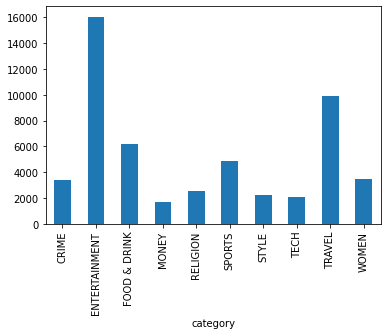

In [ ]:
dataset.groupby(['category'])['headline'].count().plot.bar()

max headline length: 44  min headline length: 1
longest title: Chats with Esperanza Spalding, Michelle Phillips, Lee Greenwood, Ian Thomas and Young Gun Silver Fox's Shawn Lee, Plus Joey Alexander, Elayna, Ultan Conlon, M Ross Perkins, Morgan's Road, Deerheart, Dave McGraw & Mandy Fer, Unconscious Disturbance, I The Mighty, and The Junior League Exclusives
shorted title: #WhyWeMarched


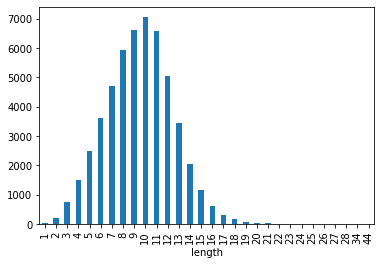

In [ ]:
dataset['length'] = dataset['headline'].apply(lambda x: len(x.split(' ')))
dataset.groupby(['length'])['headline'].count().plot.bar()
print(f"max headline length: {dataset['length'].max()}  min headline length: {dataset['length'].min()}")

print(f"longest title: {dataset['headline'].iloc[dataset['length'].argmax()]}")
print(f"shorted title: {dataset['headline'].iloc[dataset['length'].argmin()]}")

dataset = dataset.drop(['length'], axis=1)

In [ ]:
for cat in CATEGORY_SUBSET:
    rnd_ind = np.arange(1000)
    np.random.shuffle(rnd_ind)
    rnd_ind = rnd_ind[:10]
    for i in rnd_ind:
        print(cat, dataset[dataset['category']==cat]['headline'].iloc[i])

CRIME After Lawsuit, City Agrees To Stop Forcing Women To Pay Fee For Not Pressing Charges Against Abusers
CRIME Montreal Gearing Up To Sentence Huge Numbers Of Innocent Dogs To Death
CRIME Videos Capture Moment Gunman Opens Fire At Istanbul Nightclub
CRIME Shooting At Connecticut House Party Wounds 13
CRIME Bagged Heart Mysteriously Appears In Ohio Field, Stumping Police
CRIME Beloved Bipedal Bear Named Pedals Believed Killed By Hunter
CRIME Woman Alleges Rapper Young Lo Raped Her While She Was Trapped In Chris Brown's Home
CRIME Taxi Driver With Knife In His Head Walks Into Hospital
CRIME Georgia Cops Find Beheaded Voodoo Doll Outside HQ
CRIME New York's Metropolitan Opera Cancels Show After Powder Sprinkled Into Orchestra Pit
RELIGION Composting Religion
RELIGION To Trump's Christian Supporters: How Much Do You Really Have In Common With Him?
RELIGION Pixar Animator Reveals The Magic Ingredient That Adds Soul To Stories
RELIGION Stephen Fry Reportedly Faces Blasphemy Probe After Cal

## Frequent Unigrams, Bigrams, Trigrams for each category

In [ ]:
frequent_unigrams = get_frequent_ngrams_for_categories(dataset, (1,1))
print(frequent_unigrams.to_string())

               CRIME  RELIGION      TECH     MONEY  FOOD & DRINK    SPORTS    TRAVEL     WOMEN     STYLE  ENTERTAINMENT
trump       0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.044588
her         0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.055113
beauty      0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.053682       0.000000
fashion     0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.081189       0.000000
my          0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.058166  0.000000       0.000000
about       0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.074785  0.000000       0.049695
women       0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.238395  0.000000       0.000000
most        0.000000  0.000000  0.000000

In [ ]:
frequent_bigrams = get_frequent_ngrams_for_categories(dataset, (2,2))
print(frequent_bigrams.to_string())

                         CRIME  RELIGION      TECH     MONEY  FOOD & DRINK    SPORTS    TRAVEL     WOMEN     STYLE  ENTERTAINMENT
dead at               0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.008096
in new                0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.008781
kanye west            0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.009403
star wars             0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.011957
kim kardashian        0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.012081
of thrones            0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.013949
game of               0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.00

In [ ]:
frequent_trigrams = get_frequent_ngrams_for_categories(dataset, (3,3))
print(frequent_trigrams.to_string())

                             CRIME  RELIGION      TECH     MONEY  FOOD & DRINK    SPORTS    TRAVEL     WOMEN     STYLE  ENTERTAINMENT
for the first             0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.001868
taylor swift and          0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.001931
and more the              0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.001931
the first time            0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.002117
the golden globes         0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.002117
first look at             0.000000  0.000000  0.000000  0.000000      0.000000  0.000000  0.000000  0.000000  0.000000       0.002491
at the box                0.000000  0.000000  0.000000  0.0000

# Feature Engineering

## Keep Stopwords?

In [ ]:
STOPWORDS = stopwords.words("english")
ENGLISH_STOP_WORDS = set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS) )

In [ ]:
PMI_stopwords = get_PMIScore(dataset, v=ENGLISH_STOP_WORDS)
PMI_stopwords = PMI_stopwords.fillna(-1)
PMI_stopwords = PMI_stopwords[PMI_stopwords['PMIScore'] > -1]

In [ ]:
print(PMI_stopwords.to_string())

                 CRIME   RELIGION       TECH     MONEY  FOOD & DRINK    SPORTS    TRAVEL      WOMEN      STYLE  ENTERTAINMENT    PMIScore
meanwhile     0.000000   0.000000  25.239193  0.000000      0.000000  0.000000  0.000000   0.000000   0.000000       0.000000  252.391931
hereby        0.000000   0.000000   0.000000  0.000000      0.000000  0.000000  0.000000  15.056734   0.000000       0.000000  150.567335
nevertheless  0.000000   0.000000   0.000000  0.000000      0.000000  0.000000  0.000000  15.056734   0.000000       0.000000  150.567335
fifteen       0.000000   0.000000   0.000000  0.000000      8.440090  0.000000  0.000000   0.000000   0.000000       0.000000   84.400899
sometime      0.000000   0.000000   0.000000  0.000000      8.440090  0.000000  0.000000   0.000000   0.000000       0.000000   84.400899
whenever      0.000000   0.000000   0.000000  0.000000      8.440090  0.000000  0.000000   0.000000   0.000000       0.000000   84.400899
etc           0.000000   0.000000 

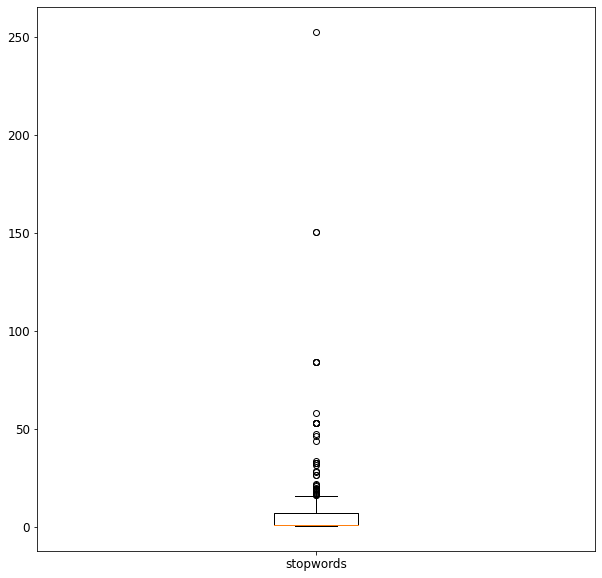

In [ ]:
labelsize = 12
plt.rcParams['xtick.labelsize'] = labelsize
plt.rcParams['ytick.labelsize'] = labelsize 

stopword_plot = plt.boxplot(PMI_stopwords['PMIScore'])
plt.xticks([1], ['stopwords'])
plt.show()

In [ ]:
low_PMIScore = np.percentile(PMI_stopwords['PMIScore'], 0.25)
PMI_stopwords[PMI_stopwords['PMIScore'] <= low_PMIScore]

,CRIME,RELIGION,TECH,MONEY,FOOD & DRINK,SPORTS,TRAVEL,WOMEN,STYLE,ENTERTAINMENT,PMIScore
show,0.347702,0.784173,0.306195,0.213406,0.219413,0.46617,0.303969,0.704561,1.171722,2.279896,0.679721


## Lemmatization?

In [ ]:
text = "Apple Has Already Patched Many Of The WikiLeaks Exploits"
tokens = nltk.word_tokenize(text)
lem = nltk.stem.wordnet.WordNetLemmatizer()
lem_tokens = [lem.lemmatize(t.lower()) for t in tokens]
lem_tokens

['apple',
 'ha',
 'already',
 'patched',
 'many',
 'of',
 'the',
 'wikileaks',
 'exploit']

In [ ]:
PMI_stopwords.loc['has']

CRIME            0.588875
RELIGION         0.730660
TECH             0.830237
MONEY            0.526566
FOOD & DRINK     0.399794
SPORTS           1.245804
TRAVEL           0.412601
WOMEN            1.030198
STYLE            1.595115
ENTERTAINMENT    1.631888
PMIScore         0.899174
Name: has, dtype: float64

## Tokenization

### Breaking Hashtags

In [ ]:
dataset['has_hashtag'] = dataset['headline'].apply(lambda x: True if re.search(r'#\w+', x) else False)
print(len(dataset[dataset['has_hashtag']]))
print(dataset[dataset['has_hashtag']].to_string())
dataset = dataset.drop(['has_hashtag'], axis=1)

217
                                                                                                      headline       category  has_hashtag
21                                        Twitter #PutStarWarsInOtherFilms And It Was Universally Entertaining  ENTERTAINMENT         True
2644                                          Molly Ringwald Unloads On 'The Breakfast Club' In The #MeToo Era  ENTERTAINMENT         True
3407                                    Elon Musk Pulls Tesla, SpaceX Facebook Pages In Nod To #DeleteFacebook           TECH         True
3858                                   Jenna Jameson Calls On Women To #DropTheCover And Celebrates Motherhood          WOMEN         True
5537                            Female Journalists Tweet #MoreThanABabe To Protest Radio Bracket Ranking Women          WOMEN         True
6193                                                                     South Korea Joins The #MeToo Movement          WOMEN         True
6306                   

In [ ]:
def break_hashtag(text):
    text_words = re.split(r'(#\w+)', text)
    texts = []
    for text_word in text_words:
      if re.match(r'#\w+', text_word):
          words = []
          i = 1
          word = ''
          while i < len(text_word):
              if text_word[i].isupper():
                  words.append(word)
                  word = text_word[i]
              else:
                  word += text_word[i]
              i += 1
          words.append(word)
          texts.append(' '.join(words).strip())
      else:
          texts.append(text_word)

    return ' '.join(texts)

def tokenize(text):
    text = break_hashtag(text)
    text = re.sub(r'[^\w]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [t.lower() for t in tokens]
    return tokens

In [ ]:
text = "#TrumpHair Is The Hilarious Hashtag Our Country Deserves"
tokenize(text)

['trump',
 'hair',
 'is',
 'the',
 'hilarious',
 'hashtag',
 'our',
 'country',
 'deserves']

### Tokenize with Bigrams

In [ ]:
dataset = get_dataset()
dataset['tokens'] = dataset['headline'].apply(tokenize)
dataset['length'] = dataset['tokens'].apply(lambda x: len(x))
dataset = dataset.reset_index()

flatdata = pd.DataFrame([( index, value) for ( index, values)
                         in dataset['tokens'].iteritems() for value in values],
                             columns = [ 'index', 'tokens']).set_index( 'index' )

tokens = flatdata['tokens'].to_numpy()

In [ ]:
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)

In [ ]:
# Find bigrams and trigrams by PMI
bigramFinder.apply_freq_filter(20)
trigramFinder.apply_freq_filter(10)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['ngram','PMI']).sort_values(by='PMI', ascending=False)
trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['ngram','PMI']).sort_values(by='PMI', ascending=False)

bigram_vocab_df = bigramPMITable[bigramPMITable['PMI'] > 6]
bigram_vocab_df['ngram'] = bigram_vocab_df['ngram'].apply(lambda x: ' '.join(x))

trigram_vocab_df = trigramPMITable[trigramPMITable['PMI'] > 6]
trigram_vocab_df['ngram'] = trigram_vocab_df['ngram'].apply(lambda x: ' '.join(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
bigram_vocab = bigram_vocab_df['ngram'].values
trigram_vocab = trigram_vocab_df['ngram'].values
vocab = list(bigram_vocab) + list(trigram_vocab)

frequency_of_bigram_trigram_vocab = get_frequent_ngrams_for_categories(dataset, (2,3), tokenizer=tokenize, v=vocab, n=len(vocab))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extra

In [ ]:
frequency_of_bigram_trigram_vocab

,CRIME,RELIGION,TECH,MONEY,FOOD & DRINK,SPORTS,TRAVEL,WOMEN,STYLE,ENTERTAINMENT
photos huffpost tastemakers,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
photos top 10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
photos recipe of,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
photos america s,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
photos how to,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
police officer,0.012628,0.000000,0.000000,0.000000,0.000000,0.000205,0.000000,0.000287,0.000000,0.000125
new york,0.014391,0.004697,0.008165,0.004101,0.004337,0.009419,0.009811,0.002292,0.011091,0.003612
charged with,0.015272,0.000391,0.000000,0.001172,0.000000,0.001843,0.000000,0.000860,0.000000,0.000747
police say,0.018502,0.000391,0.000480,0.000586,0.000000,0.000205,0.000000,0.000000,0.000000,0.000125


In [ ]:
frequency_of_bigram_trigram_vocab['std'] = frequency_of_bigram_trigram_vocab.to_numpy().std(axis=1)
vocab_to_remove = frequency_of_bigram_trigram_vocab.loc[frequency_of_bigram_trigram_vocab['std'] == 0].index

In [ ]:
vocab_to_remove

Index(['photos huffpost tastemakers', 'photos top 10', 'photos recipe of',
       'photos america s', 'photos how to', 'photos the best',
       'photos the most', 'photos world s'],
      dtype='object')

In [ ]:
vocab_df = pd.concat([bigram_vocab_df, trigram_vocab_df])
for word in vocab_to_remove:
    vocab_df = vocab_df[vocab_df['ngram']  != word]

vocab_df['token'] = vocab_df['ngram'].apply(lambda x: '_'.join(x.split(' ')))
vocab_df.to_csv(BIGRAM_TRIGRAM_VOCAB, index=False)

In [ ]:
class Bigram_Trigram_Tokenizer:
    def __init__(self):
        self.bigram_trigram_vocab = pd.read_csv(BIGRAM_TRIGRAM_VOCAB)

    def get_PMI_for_word(self, word):
        pmi = self.bigram_trigram_vocab[self.bigram_trigram_vocab['ngram']==word]['PMI'].values
        if len(pmi) == 0:
            return 0

        return pmi[0]

    def tokenize_with_bigrams(self, text):
        unigrams = tokenize(text)
        bigrams = [' '.join(t)
                   for t in list(zip(unigrams, unigrams[1:]+[" "]))]
        bigrams_pmi = [self.get_PMI_for_word(word) for word in bigrams]

        def helper(left_start, right_end):
            if left_start >= right_end:
                return ''
            max_bigram_arg = np.argmax(
                bigrams_pmi[left_start:right_end]) + left_start
            if bigrams_pmi[max_bigram_arg] > 0:
                left = helper(left_start, max_bigram_arg)
                right = helper(max_bigram_arg+2, right_end)
                bi_unigram = '_'.join(bigrams[max_bigram_arg].split(' '))
                return ' '.join([left, bi_unigram, right])
            else:
                return ' '.join(unigrams[left_start:right_end])

        ret = helper(0, len(unigrams))
        return nltk.word_tokenize(ret)

    def get_bigram_trigram_token_list(self):
        return self.bigram_trigram_vocab['token'].values

    def get_bigram_token_list(self):
        df = self.bigram_trigram_vocab.copy()
        df['len'] = df['ngram'].apply(lambda x: len(x.split(' ')))
        bigrams = df[df['len'] == 2]
        return bigrams['token'].values

    def get_bigram_glove_embeddings(self):
        embeddings = pickle.load(open(BIGRAM_VOCAB_EMBEDDINGS, 'rb'))
        return embeddings

In [ ]:
bigram_tokenizer = Bigram_Trigram_Tokenizer()
text = 'Kylie Jenner Launches #IAmMoreThan Anti-Bullying Campaign On Instagram'
bigram_tokenizer.tokenize_with_bigrams(text)

['kylie_jenner',
 'launches',
 'i_am',
 'more_than',
 'anti',
 'bullying',
 'campaign',
 'on',
 'instagram']

### Compute Bigram Glove Embeddings

In [ ]:
def glove2dict(glove_filename):
    with open(glove_filename, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=' ',quoting=csv.QUOTE_NONE)
        embed = {line[0]: np.array(list(map(float, line[1:])))
                for line in reader}
    return embed
pre_glove = glove2dict(GLOVE_50D_TXT)

In [ ]:
oov = get_bigram_token_list()
corp_vocab = {}
for i in range(len(oov)):
    corp_vocab[oov[i]] = i

def is_in_bigram_vocab(word): 
    try:
        a = corp_vocab[word]
    except:
        return False
    return True

Compute co-occurrence matrix of the bigrams in the precomputed bigram_vocab

In [ ]:
cv = CountVectorizer(tokenizer=tokenize_with_bigrams, vocabulary=corp_vocab)
X = cv.fit_transform(train_data['headline'])
Xc = (X.T * X)
Xc.setdiag(0)
coocc_ar = Xc.toarray()

If you need to take a look at the RAM in case the co-occurrence array is huge...

In [ ]:
import psutil
# gives a single float value
print(psutil.cpu_percent())
# gives an object with many fields
print(psutil.virtual_memory())
# you can convert that object to a dictionary 
print(dict(psutil.virtual_memory()._asdict()))
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

Train the mittens model on the co-occurrence array to get the glove vectors of the bigrams

In [ ]:
from mittens import Mittens

dim = 50
iter = 10000
size = len(coocc_ar)

mittens_model = Mittens(n=dim, max_iter=iter)
new_embeddings = mittens_model.fit(
      coocc_ar,
      vocab=bigram_unigram_vocab,
      initial_embedding_dict= pre_glove)

In [ ]:
newglove = dict(zip(corp_vocab, new_embeddings))
pickle.dump(newglove, open(os.path.join(WORKING_DIR, f"mitten_bigram_dict_{dim}d_{size}_{iter}.pkl"), "wb"))

Sanity check using k-nearest neighbors: the bigrams that are "similar" in meaning should be "close" to each other

In [ ]:
newglove_word2ind = {}
newglove_ind2word = []
for ind, key in enumerate(newglove):
    newglove_word2ind[key] = ind 
    newglove_ind2word.append(key)

newglove_arr = []
for k in newglove_ind2word:
    newglove_arr.append(newglove[k])

newglove_arr = np.array(newglove_arr)

In [ ]:
from sklearn.neighbors import NearestNeighbors

X = newglove_arr
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

for i in indices:
    print(newglove_ind2word[i[0]], newglove_ind2word[i[1]], newglove_ind2word[i[2]])

### Tokenize with Synonyms and Hypernyms

In [ ]:
def tokenize_synonyms(text):
    synsets = []
    tokens = tokenize(text)
    for token in tokens:
        synsetss = wn.synsets(token)
        s_set = []
        for s in synsetss:
            s_set.append(s.lemmas()[0].name().lower())
        s_set.sort()
        if len(s_set) > 0:
            synsets += s_set[0].split("_")

    return synsets

def tokenize_hypernyms(text):
    synsets = []
    tokens = tokenize(text)
    for token in tokens:
        synsetss = wn.synsets(token)
        h_set = []
        for s in synsetss:
            for h in s.hypernyms():
                h_set.append(h.lemmas()[0].name().lower())

        h_set.sort()
        if len(h_set) > 0:
            synsets += h_set[0].split("_")
            
    return synsets

In [ ]:
text = "Eating Healthy Just Got Easy With These 20 Recipes (PHOTOS)"
print(tokenize_synonyms(text))

['consume', 'goodly', 'barely', 'arrive', 'comfortable', 'twenty', 'recipe', 'photograph']


In [ ]:
tokenize_hypernyms(text)

['consume', 'annoy', 'large', 'integer', 'direction', 'representation']

In [ ]:
text = "Nigeria And Jamaica Just Made Winter Olympics History"
tokenize_synonyms(text)

['nigeria',
 'jamaica',
 'barely',
 'cause',
 'winter',
 'olympic',
 'games',
 'history']

In [ ]:
tokenize_hypernyms(text)

['achieve', 'season', 'athletic', 'contest', 'cognition']

In [ ]:
def get_hypernyms_for_text(text):
  hypersets = {}
  tokens = tokenize(text)
  for token in tokens:
    synsetss = wn.synsets(token)
    for s in synsetss:
      for h in s.hypernyms():
        if h in hypersets:
          hypersets[h] += 1
        else:
          hypersets[h] = 1
  return hypersets

def get_synonyms_for_text(text):
  synsets = {}
  tokens = tokenize(text)
  for token in tokens:
    synsetss = wn.synsets(token)
    for s in synsetss:
      if s in synsets:
        synsets[s] += 1
      else:
        synsets[s] = 1

  return synsets

def get_all_synsets(synset_dict_lst, count_limit=None):
  all_synsets = {}
  for synset_dict in synset_dict_lst:
    for _, key in enumerate(synset_dict):
      if key in all_synsets:
        all_synsets[key] += synset_dict[key]
      else:
        all_synsets[key] = synset_dict[key]

  if count_limit is not None and count_limit > 0:
    key_to_remove = []
    for _, key in enumerate(all_synsets):
      if all_synsets[key] < count_limit:
        key_to_remove.append(key)

    for key in key_to_remove:
      all_synsets.pop(key, None)
  return all_synsets

In [ ]:
category_hypernym_dict_lst = []
category_synonym_dict_lst = []

for cat in CATEGORY_SUBSET:
  cat_data = dataset[dataset['category']==cat]
  cat_data['hypernyms'] = cat_data['headline'].apply(lambda x: get_hypernyms_for_text(x))
  cat_data['synonyms'] = cat_data['headline'].apply(lambda x: get_synonyms_for_text(x))
  all_hypernym_synsets = get_all_synsets(cat_data['hypernyms'].values, count_limit=len(cat_data)*0.005)
  all_synonym_synsets = get_all_synsets(cat_data['synonyms'].values, count_limit=len(cat_data)*0.005)
  category_hypernym_dict_lst.append(all_hypernym_synsets)
  category_synonym_dict_lst.append(all_synonym_synsets)

In [ ]:
for i in range(10):
  print(len(category_synonym_dict_lst[i]), CATEGORY_SUBSET[i])

In [ ]:
for i in range(10):
  print(len(category_hypernym_dict_lst[i]), CATEGORY_SUBSET[i])

In [ ]:
all_hypernym_synsets = get_all_synsets(category_hypernym_dict_lst)
all_synonym_synsets = get_all_synsets(category_synonym_dict_lst)

print(len(all_synonym_synsets))
print(len(all_hypernym_synsets))

In [ ]:
train_data = train_test_split()
train_data = train_data[train_data['phase'] == 'train']

In [ ]:
PMI_unigram = get_PMIScore(train_data, tokenizer=tokenize)
PMI_bigram = get_PMIScore(train_data, tokenizer=bigram_tokenizer.tokenize_with_bigrams)
PMI_synonym = get_PMIScore(train_data, tokenizer=tokenize_synonyms)
PMI_hypernym = get_PMIScore(train_data, tokenizer=tokenize_hypernyms)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


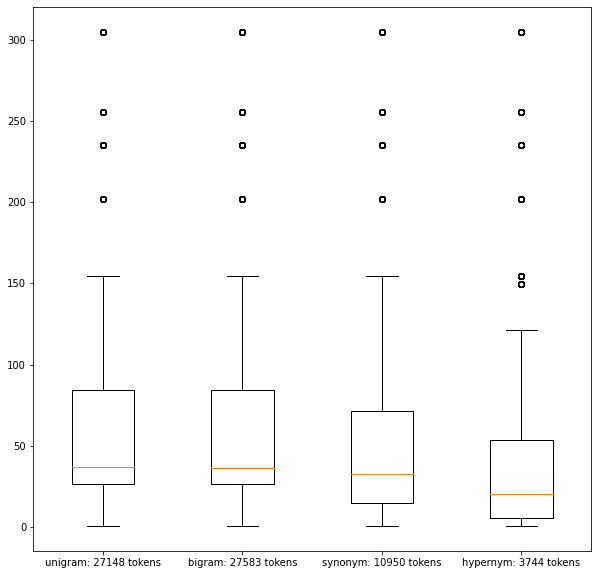

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
labelsize = 10
plt.rcParams['xtick.labelsize'] = labelsize
plt.rcParams['ytick.labelsize'] = labelsize 
plt.boxplot([PMI_unigram['PMIScore'], PMI_bigram['PMIScore'], PMI_synonym['PMIScore'], PMI_hypernym['PMIScore']])
plt.xticks([1, 2, 3, 4], [f'unigram: {len(PMI_unigram)} tokens', f'bigram: {len(PMI_bigram)} tokens', f'synonym: {len(PMI_synonym)} tokens', f'hypernym: {len(PMI_hypernym)} tokens'])
plt.show()